In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from keras.utils import np_utils
from numpy import random
from random import seed
import math
import wandb

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [7]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [8]:
# Split data for cross validation
x_val = x_train[54000:]
y_val = y_train[54000:]
x_train = x_train[:54000]
y_train = y_train[:54000]  

In [9]:
print("x_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)
print(y_train)

x_train original shape (54000, 28, 28)
y_train original shape (54000,)
[9 0 0 ... 5 3 9]


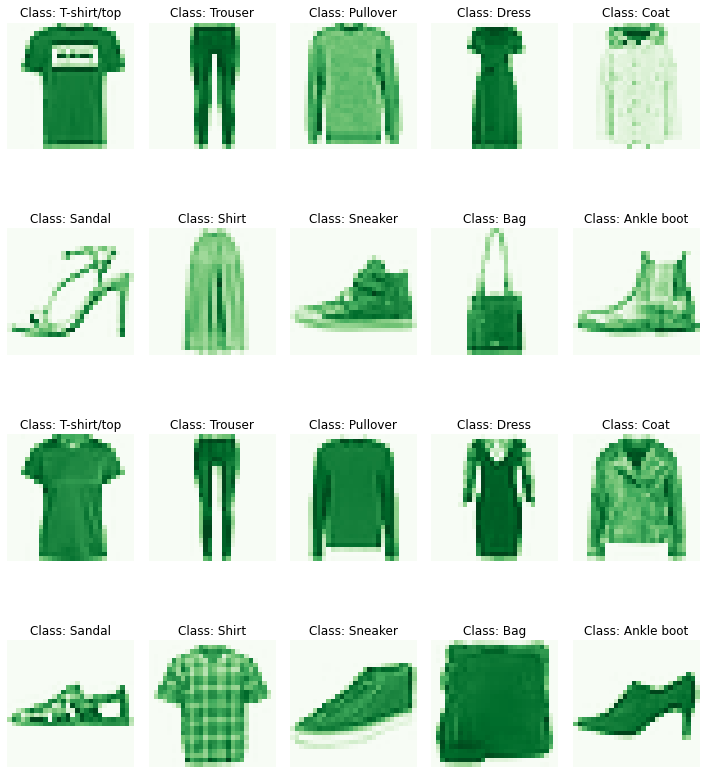

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(10,12))

for i in range(20):
    plt.subplot(4,5,i+1)
    img = x_train[y_train == (i%10)][i%10+i]
    plt.imshow(img, cmap='Greens', interpolation='none')
    plt.title("Class: {}".format(class_names[i%10]))
    plt.axis('off')
    
plt.tight_layout()

In [11]:
# turn the data into an appropriate matrix form
x_train = np.reshape(x_train, (54000, 784, 1))
y_train = np.reshape(y_train, (54000, 1))

In [12]:
x_test = np.reshape(x_test, (10000, 784, 1))
y_test = np.reshape(y_test, (10000, 1))

In [13]:
x_val = np.reshape(x_val, (6000, 784, 1))
y_val = np.reshape(y_val, (6000, 1))

In [14]:
# One-hot encoding
targs = np.zeros((54000, 10, 1))
for i in range(54000):
    targs[i][y_train[i][0]-1][0] = 1 # preparing the target matrix 

In [15]:
targs_test = np.zeros((10000, 10, 1))
for i in range(10000):
    targs_test[i][y_test[i][0]-1][0] = 1 # preparing the target matrix 

In [16]:
targs_val = np.zeros((6000, 10, 1))
for i in range(6000):
    targs_val[i][y_val[i][0]-1][0] = 1 # preparing the target matrix 

In [17]:
# normalize data
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

In [18]:
wandb.init(project="DL_Assignment_1", entity="cs21m010-cs21m041")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs, n_layers, config):
    network = list()
    randomMultiplier = 0.01
    
    for i in range(n_layers):
        hidden_layer = {}
        weights = None
        bias = None
        if i==0:
            if config.initialization=="random":
                weights = randomMultiplier * np.random.randn(n_hidden, n_inputs)
            else:
                weights = randomMultiplier * (np.random.randn(n_hidden, n_inputs)) 
                if config.activation == "relu":
                    weights = weights * math.sqrt(2 / n_inputs)
                else:
                    weights = weights * math.sqrt(1 / n_inputs)
            bias = np.zeros([n_hidden, 1])
        else:
            if config.initialization=="random":                                  
                weights = randomMultiplier * np.random.randn(n_hidden, n_hidden)
            else:
                weights = randomMultiplier * (np.random.randn(n_hidden, n_hidden)) 
                if config.activation == "relu":
                    weights = weights * math.sqrt(2 / n_inputs)
                else:
                    weights = weights * math.sqrt(1 / n_inputs)
                                              
            bias = np.zeros([n_hidden, 1])

        hidden_layer['weights'] = weights
        hidden_layer['bias'] = bias
        network.append(hidden_layer)
    
    # Weights and bias for output layer
    output_layer = {}
    if config.initialization=="random":                                  
        weights = randomMultiplier * np.random.randn(n_outputs, n_hidden)
    else:
        weights = randomMultiplier * (np.random.randn(n_outputs,n_hidden)) 
        if config.activation == "relu":
              weights = weights * math.sqrt(2 / n_inputs)
        else:
              weights = weights * math.sqrt(1 / n_inputs)                                        
#     weights = randomMultiplier * np.random.randn(n_outputs, n_hidden)
    bias = np.zeros([n_outputs, 1])
    output_layer['weights'] = weights
    output_layer['bias'] = bias
    network.append(output_layer)
    
    return network

In [20]:
### Activation Functions starts

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def sigmoidGrad(dA, prevZ):
    s = sigmoid(prevZ)
    dZ = dA * s * (1 - s)
    return dZ

def relu(Z):
    A = np.maximum(0, Z)
    return A
    
def reluGrad(dA, prevZ):
    s = np.maximum(0, prevZ)
    dZ = (s>0) * 1 * dA
    return dZ 

def tanh(Z):
    A = np.tanh(Z)
    return A

def tanhGrad(dA, prevZ):
    s = np.tanh(prevZ)
    dZ = (1 - s**2) * dA
    return dZ

def linear(Z):
    return Z
 
def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

def crossEntropyLoss(Y, A, epsilon=1e-15):
    m = Y.shape[1]
    loss = -1 * (Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
    cost = 1 / m * np.sum(loss)
    return np.squeeze(cost)

### Activation Functions ends

In [21]:
# Intializing activationForward and activationBackward globally
activationForward = None
activationBackward = None

# Function to set forward and backward activation functions
def setActivationFns(activationName):
    global activationForward
    global activationBackward

    print('setting activation function as: ', activationName)
    if activationName == 'sigmoid':
        activationForward = sigmoid
        activationBackward = sigmoidGrad
    elif activationName == 'tanh':
        activationForward = tanh
        activationBackward = tanhGrad
    elif activationName == 'relu':
        activationForward = relu
        activationBackward = reluGrad
    else:
        print('invalid activation name') 


In [22]:
# Method to print Accuracy
def printAccuracy(network, x_test, targs_test):
    predictedCorrect = 0
    predictedWrong = 0
    for n in range(len(x_test)):
        ins = x_test[n]
        A = forward_propagate(network, ins)
        classPredicted = np.argmax(A, axis=0)[0]
        classActual = np.argmax(targs_test[n], axis=0)[0]
        if (classPredicted == classActual):
            predictedCorrect = predictedCorrect + 1
        else:
            predictedWrong = predictedWrong + 1
    accuracy = predictedCorrect / len(x_test) 
    print('Accuracy: ', accuracy)
    return accuracy

In [23]:
### Common Utils Starts

def resetdbanddW(network):
    for layer in network:
        m, n = layer['weights'].shape
        layer['dW'] = np.zeros([m, n])
        m, n = layer['bias'].shape
        layer['db'] = np.zeros([m, n])

def initialize_v_w_and_v_b(network):
    for layer in network:
        m, n = layer['weights'].shape
        layer['v_w'] = np.zeros([m, n])
        m, n = layer['bias'].shape
        layer['v_b'] = np.zeros([m, n])

def update_v_w_and_v_b(network, gamma):
    for layer in network:
        layer['v_w'] = gamma * layer['prev_v_w']
        layer['v_b'] = gamma * layer['prev_v_b']

def initialize_prev_v_w_and_prev_v_b(network):
    for layer in network:
        m, n = layer['weights'].shape
        layer['prev_v_w'] = np.zeros([m, n])
        m, n = layer['bias'].shape
        layer['prev_v_b'] = np.zeros([m, n])

### Common Utils Ends

In [24]:
setActivationFns("sigmoid")

setting activation function as:  sigmoid


In [25]:
# Forward propagate input to a network output

def forward_propagate(network, X):
    x = np.copy(X)

    # Apply sigmoid for all previous layers
    for layer in network[:-1]:
        Z = np.dot(layer['weights'], x) + layer['bias']
        layer['prevZ'] = Z  # Preactivation values of current layer
        layer['prevA'] = x  # Activation values of previous layer
        x = activationForward(Z) 

    # Apply softmax for the final layer
    layer = network[-1]
    Z = np.dot(layer['weights'], x) + layer['bias']
    layer['prevZ'] = Z
    layer['prevA'] = x
    x = softmax(Z)
    return x

In [26]:
# Back propagation
def backward_propagation(network, actual, predicted):
    dZ = -(actual - predicted)
    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] +  1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [27]:
def update(network, learning_rate):
    for layer in network:
        layer['weights'] = layer['weights'] - learning_rate * layer['dW']
        layer['bias'] = layer['bias'] - learning_rate * layer['db']

In [28]:
# Stochastic Gradient Descent

In [29]:
def optimser_sgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        no_of_steps=0
        resetdbanddW(network)
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update(network, config.learning_rate)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)
      

In [30]:
def calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost):
    epoch+=1
    total_cost_val=0
    for n in range(6000):
        ins = x_val[n]
        target = targs_val[n]
        A = forward_propagate(network, ins)
        total_cost_val = total_cost_val + crossEntropyLoss(target, A)

    accuracy_val = printAccuracy(network, x_val, targs_val)
    accuracy_test = printAccuracy(network, x_test, targs_test)
    total_cost = total_cost / 54000 
    total_cost_val = total_cost_val / 6000
    wandb.log({"val_loss": total_cost_val, "val_accuracy": accuracy_val, "loss": total_cost, "accuracy": accuracy_test, "epochs": epoch })



In [31]:
# Momentum Gradient Descent

In [32]:
# Back propagation for mgd
def backward_propagation_mgd(network, actual, predicted):
    dZ = -(actual - predicted)
    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] + 1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [33]:
def update_mgd(network, learning_rate, gamma):
    for layer in network:
        v_w = gamma * layer['prev_v_w'] + learning_rate * layer['dW']
        v_b = gamma * layer['prev_v_b'] + learning_rate * layer['db']

        layer['weights'] = layer['weights'] - v_w
        layer['bias'] = layer['bias'] - v_b

        layer['prev_v_w'] = v_w
        layer['prev_v_b'] = v_b

In [34]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=784
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('tanh')

In [35]:
def optimser_mgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_prev_v_w_and_prev_v_b(network)
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        resetdbanddW(network)
        no_of_steps=0
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation_mgd(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update_mgd(network, config.learning_rate, gamma=0.9)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

In [36]:
# Nesterov Accelerated Gradient Descent

In [37]:
# Forward propagate for NAGD
def forward_propagate_nagd(network, X):
    x = np.copy(X)
    nagdx = np.copy(X)

    # Apply activationForward for all previous layers
    for layer in network[:-1]:
        Z = np.dot(layer['weights'], x) + layer['bias']
        nagdZ = np.dot(layer['weights'] - layer['v_w'], nagdx) + layer['bias'] - layer['v_b']
        
        layer['prevZ'] = Z  # Preactivation values of current layer
        layer['prevA'] = x  # Activation values of previous layer

        layer['prevnagdZ'] = nagdZ  # Preactivation values of current layer
        layer['prevnagdA'] = nagdx # Activation values of previous layer

        x = activationForward(Z) 
        nagdx = activationForward(nagdZ)

    # Apply softmax for the final layer
    layer = network[-1]
    Z = np.dot(layer['weights'], x) + layer['bias']
    nagdZ = np.dot(layer['weights'] - layer['v_w'], nagdx) + layer['bias'] - layer['v_b']
    layer['prevZ'] = Z
    layer['prevA'] = x
    layer['prevnagdZ'] = nagdZ
    layer['prevnagdA'] = nagdx
    # x = softmax(Z)
    nagdx = softmax(nagdZ)
    return nagdx

In [38]:
# Back propagation for NAGD
def backward_propagation_nagd(network, actual, predicted):
    dZ = -(actual - predicted)
    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] + 1 / m * np.dot(dZ, network[i]['prevnagdA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevnagdZ'])

In [39]:
# Update for nagd
def update_nagd(network, learning_rate, gamma):
    for layer in network:
        v_w = gamma * layer['prev_v_w'] + learning_rate * layer['dW']
        v_b = gamma * layer['prev_v_b'] + learning_rate * layer['db']

        layer['weights'] = layer['weights'] - v_w
        layer['bias'] = layer['bias'] - v_b

        layer['prev_v_w'] = v_w
        layer['prev_v_b'] = v_b

In [40]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=784
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('relu')

In [41]:
def optimser_nagd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_prev_v_w_and_prev_v_b(network)
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        resetdbanddW(network)
        no_of_steps=0
        update_v_w_and_v_b(network, gamma=0.9)
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate_nagd(network, ins)
            backward_propagation_nagd(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update_nagd(network, config.learning_rate, gamma=0.9)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

In [42]:
# RMSProp

In [43]:
# Back propagation for mgd
def backward_propagation_rmsprop(network, actual, predicted):
    dZ = -(actual - predicted)
    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] + 1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [44]:
def update_rmpsprop(network, learning_rate, beta1, eps=1e-8):
    for layer in network:
      layer['v_w'] = beta1 * layer['v_w'] + (1 - beta1) * layer['dW']**2
      layer['v_b'] = beta1 * layer['v_b'] + (1 - beta1) * layer['db']**2

      layer['weights'] = layer['weights'] - (learning_rate / np.sqrt(layer['v_w'] + eps)) * layer['dW']
      layer['bias'] = layer['bias'] - (learning_rate / np.sqrt(layer['v_b'] + eps)) * layer['db']

In [45]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=784
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('sigmoid')

In [46]:
def optimser_rmsprop(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_v_w_and_v_b(network)
    eps, beta1 = 1e-8, 0.9
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        resetdbanddW(network)
        no_of_steps=0
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation_rmsprop(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update_rmpsprop(network, config.learning_rate, beta1=beta1, eps=eps)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

In [47]:
# Adam

In [48]:
def backward_propagation_adam(network, actual, predicted):
    dZ = -(actual - predicted)
    for i in range(len(network) - 1, -1, -1):

        m = network[i]['prevA'].shape[1]
        network[i]['dW'] += 1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] += 1 / m * np.sum(dZ)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [49]:
def update_adam(network, epoch, learning_rate, beta1, beta2, optimizer):
    
        for layer in network:
            if epoch!=0:
                layer['m_w']=beta1*layer['m_w'] + (1-beta1)*layer['dW']
                layer['m_b']=beta1*layer['m_b'] + (1-beta1)*layer['db']

                layer['v_w']=beta2*layer['v_w'] + (1-beta2)*np.square(layer['dW'])
                layer['v_b']=beta2*layer['v_b'] + (1-beta2)*np.square(layer['db'])

            else:
                layer['m_w']= (1-beta1)*layer['dW']
                layer['m_b']= (1-beta1)*layer['db']

                layer['v_w']=(1-beta2)*np.square(layer['dW'])
                layer['v_b']= (1-beta2)*np.square(layer['db'])

            if optimizer=="adam":
                layer['m_w_hat']=layer['m_w']/(1-math.pow(beta1,epoch+1))
            else:
                layer['m_w_hat']=layer['m_w']*beta1+(1-beta1)*layer['dW']/(1-math.pow(beta1,epoch+1))
                
            layer['m_b_hat']=layer['m_b']/(1-math.pow(beta1,epoch+1))

            layer['v_w_hat']=layer['v_w']/(1-math.pow(beta2,epoch+1))
            layer['v_b_hat']=layer['v_b']/(1-math.pow(beta2,epoch+1))
        
        
            layer['weights'] = layer['weights'] - (learning_rate / np.sqrt(layer['v_w_hat'] + learning_rate))*layer['m_w_hat'] 
            layer['bias'] = layer['bias'] - (learning_rate / np.sqrt(layer['v_b_hat'] + learning_rate))*layer['m_b_hat']


In [50]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=10
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('sigmoid')

In [51]:
def optimser_adam(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_prev_v_w_and_prev_v_b(network)
    for epoch in range(config.number_of_epochs):
        no_of_steps=0
        beta1,beta2=0.9,0.999
        total_cost=0
        resetdbanddW(network)
        for n in range(1000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation_adam(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                  update_adam(network, epoch, config.learning_rate, beta1, beta2,config.optimizer)
                  resetdbanddW(network)
                  no_of_steps=0
        total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost) 

In [52]:
sweep_config = {
  "name" : "Final_sweep",
  "method" : "random",
  "parameters" : {
    "neurons_hidden_layer" : {
      "values" : [32, 64, 128]
      # "values" : [32]
    },
    "number_of_epochs" : {
        "values" : [5,10]
        # "values" : [10]
    },
    "activation" : {
        "values" : ["sigmoid" , "relu" , "tanh"]
    },
    "no_of_hidden_layer" : {
      "values" : [3, 4, 5]
      # "values" : [2]
    },
    "batch_size" :{
      "values" : [16,32,64]
    },
    "optimizer" : {
        "values" : ["adam", "rmsprop" ,"nadam" , "sgd" , "momentum" , "nesterov"]
        # "values" : ["adam"]
    },
    "initialization": {
      "values" : ["random", "xavier"]  
    },
    "weight_decay" : {
        "values" : [0, 0.0005, 0.5]
    },
    "learning_rate" :{
      "values" : [0.1,0.01,0.001]
    }
  }
}
sweep_id = wandb.sweep(sweep_config,project="DL_Assignment_1",entity="cs21m010-cs21m041")

Create sweep with ID: ke6uzr3i
Sweep URL: https://wandb.ai/cs21m010-cs21m041/DL_Assignment_1/sweeps/ke6uzr3i


In [53]:
def train(config=None):

    # Initialize a new wandb run
    with wandb.init(config=config) as run:

        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        # hl_3_bs_16_ac_tanh 
        sweep_name = 'hl_{}_bs_{}_ac_{}_{}'.format(config.no_of_hidden_layer, config.batch_size, config.activation, config.optimizer)
        print(sweep_name)
        run.name = sweep_name
        
        np.random.seed(0)
        no_of_inputs=784
        no_of_neurons_in_hidden_layer=config.neurons_hidden_layer
        no_of_classes=10
        no_of_hidden_layers=config.no_of_hidden_layer
        network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers, config )
                    
        if config.optimizer=="sgd":
            optimser_sgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="momentum":
            optimser_mgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="nesterov":
            optimser_nagd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="rmsprop":
            optimser_rmsprop(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="adam":
            optimser_adam(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        else:
            optimser_adam(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)

In [54]:
wandb.agent(sweep_id, train, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: s8hlvufi with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_hidden_layer: 32
wandb: 	no_of_hidden_layer: 2
wandb: 	number_of_epochs: 10
wandb: 	optimizer: rmsprop


hl_2_bs_16_ac_relu_rmsprop
setting activation function as:  relu
Total cost for this epoch:  559985.0876442353
Total cost for this epoch:  970604.4449951616
Total cost for this epoch:  1006963.4229173192
Accuracy:  0.5535
Accuracy:  0.5542


accuracy,▁
epochs,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.5542
epochs,3
loss,18.64747
val_accuracy,0.5535
val_loss,21.72708


wandb: Agent Starting Run: za095c6c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_hidden_layer: 32
wandb: 	no_of_hidden_layer: 2
wandb: 	number_of_epochs: 10
wandb: 	optimizer: sgd
wandb: Currently logged in as: harishpilla (use `wandb login --relogin` to force relogin)


hl_2_bs_32_ac_tanh_sgd
setting activation function as:  tanh
Total cost for this epoch:  175312.02790627195
Total cost for this epoch:  126228.49152881715
Total cost for this epoch:  85718.94032591632
Total cost for this epoch:  74274.70109935592
Total cost for this epoch:  63951.55757942879
Accuracy:  0.7606666666666667
Accuracy:  0.7486
Total cost for this epoch:  56706.910829604974
Total cost for this epoch:  51836.56010945056
Total cost for this epoch:  48741.4345315394
Total cost for this epoch:  46599.163204821096
Total cost for this epoch:  44979.98528336788
Accuracy:  0.8301666666666667
Accuracy:  0.8214


accuracy,▁█
epochs,▁█
loss,█▁
val_accuracy,▁█
val_loss,█▁
accuracy,0.8214
epochs,10
loss,0.83296
val_accuracy,0.83017
val_loss,0.83832


wandb: Agent Starting Run: nxtmfy8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_hidden_layer: 32
wandb: 	no_of_hidden_layer: 2
wandb: 	number_of_epochs: 10
wandb: 	optimizer: nesterov


hl_2_bs_64_ac_relu_nesterov
setting activation function as:  relu
Total cost for this epoch:  175694.5422818594
Total cost for this epoch:  175697.30263056076
Total cost for this epoch:  175697.297777857
Accuracy:  0.1055
Accuracy:  0.1


accuracy,▁
epochs,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.1
epochs,3
loss,3.25365
val_accuracy,0.1055
val_loss,3.25508


wandb: Agent Starting Run: ceew9gf3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_hidden_layer: 32
wandb: 	no_of_hidden_layer: 2
wandb: 	number_of_epochs: 10
wandb: 	optimizer: nadam


hl_2_bs_32_ac_relu_nadam
setting activation function as:  relu


wandb: ERROR Run ceew9gf3 errored: TypeError('update_adam() takes 5 positional arguments but 6 were given')
wandb: Agent Starting Run: zbb8fnli with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_hidden_layer: 32
wandb: 	no_of_hidden_layer: 2
wandb: 	number_of_epochs: 10
wandb: 	optimizer: rmsprop


hl_2_bs_64_ac_tanh_rmsprop
setting activation function as:  tanh
Total cost for this epoch:  101273.56534473691
Total cost for this epoch:  62357.84451352949
Total cost for this epoch:  45345.77619401995
Accuracy:  0.8426666666666667
Accuracy:  0.8334


accuracy,▁
epochs,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.8334
epochs,3
loss,0.83974
val_accuracy,0.84267
val_loss,0.773
